<a href="https://colab.research.google.com/github/nurHasya19/FaceRecognition/blob/main/facerecognitionmine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mtcnn

In [ ]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# MTCNN for face detection
from mtcnn.mtcnn import MTCNN

class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        results = self.detector.detect_faces(img)

        if results:
            x, y, w, h = results[0]['box']
            x, y = abs(x), abs(y)
            face = img[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        else:
            return None

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_face(path)
                if single_face is not None:
                    FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)

In [ ]:
# FaceNet part
!pip install keras-facenet
from keras_facenet import FaceNet

In [ ]:
embedder = FaceNet()

In [ ]:
def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (None x 160 x 160 x 3)
    yhat = embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [ ]:
faceloading = FACELOADING("/content/drive/MyDrive/DATASET/DATASET")
X, Y = faceloading.load_classes()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 85ms/step
Loaded successfully: 106
1/1 [==============================] - 0s 75ms/step
Loaded successfully: 100
1/1 [==============================] - 0s 38ms/step
Loaded successfully: 219
1/1 [==============================] - 0s 63ms/step
Loaded successfully: 142


In [ ]:
EMBEDDED_X = []

In [ ]:
for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 117ms/step


In [ ]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

In [ ]:
# Training and testing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
# Load your FaceNet embeddings and labels
data = np.load('faces_embeddings_done_4classes.npz')
EMBEDDED_X = data['arr_0']
Y = data['arr_1']

In [ ]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(EMBEDDED_X, Y, test_size=0.2, random_state=42)


In [ ]:
# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

In [ ]:
# Define a simple classification model
classification_model = Sequential()
classification_model.add(Dense(128, input_dim=512, activation='relu'))
classification_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [ ]:
# Initialize empty lists to collect accuracy and loss values
train_accuracy = []
valid_accuracy = []
train_loss = []
valid_loss = []

In [ ]:
classification_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the classification model
batch_size = 32
epochs = 200
history = classification_model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid_encoded))

Epoch 1/200
53/53 [==============================] - 2s 12ms/step - loss: 2.0064 - accuracy: 0.7536 - val_loss: 1.1552 - val_accuracy: 0.9289
Epoch 2/200
53/53 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.9716 - val_loss: 0.3220 - val_accuracy: 0.9905
Epoch 3/200
53/53 [==============================] - 0s 6ms/step - loss: 0.2169 - accuracy: 0.9947 - val_loss: 0.1357 - val_accuracy: 0.9929
Epoch 4/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1025 - accuracy: 0.9970 - val_loss: 0.0781 - val_accuracy: 0.9976
Epoch 5/200
53/53 [==============================] - 0s 5ms/step - loss: 0.0614 - accuracy: 0.9982 - val_loss: 0.0517 - val_accuracy: 0.9976
Epoch 6/200
53/53 [==============================] - 0s 5ms/step - loss: 0.0416 - accuracy: 0.9994 - val_loss: 0.0382 - val_accuracy: 0.9976
Epoch 7/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0297 - accuracy: 0.9988 - val_loss: 0.0294 - val_accuracy: 0.9976
Epoch 8/200


In [ ]:
# Collect accuracy and loss values at each epoch
for i in range(epochs):
    y_train_pred_prob = classification_model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)
    train_accuracy.append(accuracy_score(y_train_encoded, y_train_pred))
    train_loss.append(history.history['loss'][i])

    y_valid_pred_prob = classification_model.predict(X_valid)
    y_valid_pred = np.argmax(y_valid_pred_prob, axis=1)
    valid_accuracy.append(accuracy_score(y_valid_encoded, y_valid_pred))
    valid_loss.append(history.history['val_loss'][i])

14/14 [==============================] - 0s 2ms/step


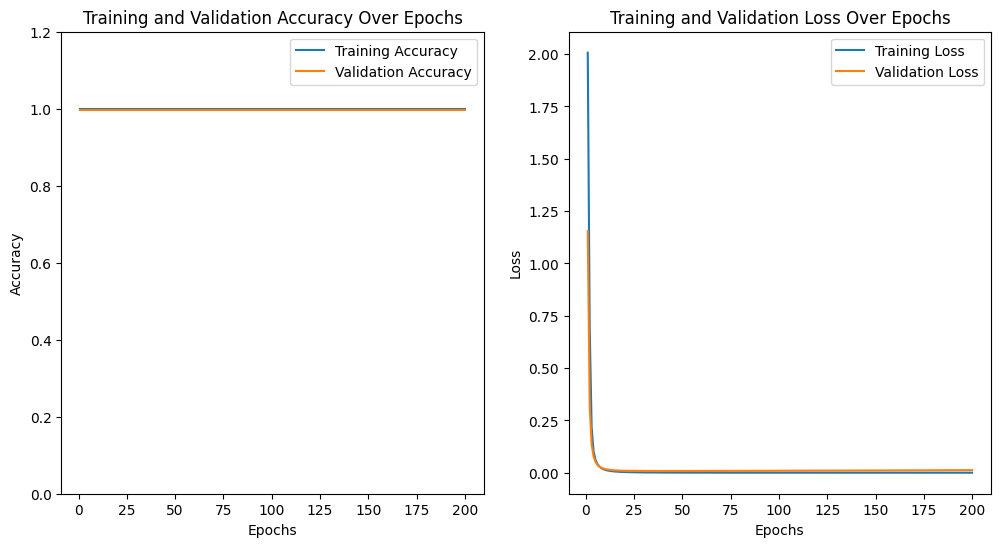

In [ ]:
#Plot training and validation accuracy with a custom y-axis range
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs+1), valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.ylim([0.0, 1.2])  # Set the y-axis range (0.0 to 1.0) for accuracy
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, epochs+1), valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.show()

In [ ]:
# Evaluate the classification model on the validation set
y_valid_pred_prob = classification_model.predict(X_valid)
y_valid_pred = np.argmax(y_valid_pred_prob, axis=1)
accuracy = accuracy_score(y_valid_encoded, y_valid_pred)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# Print accuracy, training loss, and validation loss
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Training Loss: ", history.history['loss'])
print("Validation Loss: ", history.history['val_loss'])

Validation Accuracy: 99.76%
Training Loss:  [2.0063796043395996, 0.6902801990509033, 0.21693870425224304, 0.10247039049863815, 0.06138741970062256, 0.041619401425123215, 0.029699472710490227, 0.02216527797281742, 0.01712740585207939, 0.01375250332057476, 0.011144520714879036, 0.009331544861197472, 0.007892447523772717, 0.006761777680367231, 0.005857981275767088, 0.005116672720760107, 0.0045411791652441025, 0.004037380684167147, 0.003616099013015628, 0.003247746964916587, 0.0029534269124269485, 0.00267807487398386, 0.002436589915305376, 0.0022332975640892982, 0.002058155834674835, 0.0018894379027187824, 0.0017488133162260056, 0.001623644377104938, 0.0015041637234389782, 0.0014053491177037358, 0.0013148459838703275, 0.0012243564706295729, 0.0011476496001705527, 0.0010762761812657118, 0.0010109634604305029, 0.0009498869767412543, 0.0008952348725870252, 0.0008484505815431476, 0.0008014545892365277, 0.0007567441207356751, 0.000714556488674134, 0.0006769826868548989, 0.0006424669991247356, 0

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)  # You can customize kernel and C

In [ ]:
# Reshape the embeddings to 2D (number of samples, number of features)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

In [ ]:
# Train the SVM classifier
svm_classifier.fit(X_train_flattened, y_train_encoded)

SVC(kernel='linear', probability=True)

In [ ]:
# Reshape the embeddings from your validation or test dataset
X_valid_flattened = X_valid.reshape(X_valid.shape[0], -1)

In [ ]:
# Predict class labels using the SVM classifier
svm_valid_preds = svm_classifier.predict(X_valid_flattened)

In [ ]:
# Calculate validation accuracy
svm_valid_accuracy = accuracy_score(y_valid_encoded, svm_valid_preds)

In [ ]:
print("SVM Validation Accuracy: {:.2f}%".format(svm_valid_accuracy * 100))

SVM Validation Accuracy: 99.76%


In [ ]:
import pickle

# Save the trained SVM model to a file
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

In [ ]:
import cv2 as cv
import numpy as np
from sklearn.svm import SVC
import pickle

In [ ]:
# Load the pre-trained SVM model
with open('svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

In [ ]:
# Load the test image
t_im = cv.imread("/content/drive/MyDrive/DATASET/Hasya.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)

In [ ]:
from mtcnn.mtcnn import MTCNN

# Assuming that MTCNN detection works as before
detector = MTCNN()

x, y, w, h = detector.detect_faces(t_im)[0]['box']
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160, 160))

1/1 [==============================] - 0s 199ms/step


In [ ]:
# Extract embeddings using your get_embedding function
test_im = get_embedding(t_im)
test_im_flattened = test_im.reshape(1, -1)  # Reshape for a single sample

1/1 [==============================] - 0s 207ms/step


In [ ]:
# Make a prediction on the test image using the SVM model
predicted_label = svm_model.predict(test_im_flattened)

In [ ]:
# Inverse transform to get the person's name (assuming you have a label encoder)
person_name = label_encoder.inverse_transform(predicted_label)

In [ ]:
# Get the probability of the prediction
predicted_prob = svm_model.predict_proba(test_im_flattened)
max_prob = np.max(predicted_prob) * 100

In [ ]:
print(f"Predicted Person: {person_name[0]}")
print(f"Prediction Probability: {max_prob:.2f}%")

Predicted Person: Hasya
Prediction Probability: 89.47%
